In [20]:
import numpy as np
import networkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
from shapely import wkt
import os
import seaborn as sns
import matplotlib
# 设置全局字体
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']  # 可以替换为你喜欢的其他字体


# Distribution of k*

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib import scale 

def draw_hist(df, cbg_counts =[6288, 2509, 2183, 1568, 972, 1336, 929, 845, 946, 583], year = "", save = False, suffix = ""):

    fig, ax = plt.subplots(figsize=(10, 6))
    # 画箱线图
    green = (30/255, 134/255, 51/255)
    blue = (25/255,97/255,147/255)
    red = (201/255,	0/255,	42/255	)
    boxprops = dict(color=blue)
    medianprops = dict(color=green)
    whiskerprops = dict(color='Black')
    
    #palette = ["#cea518", "#397b22", "#5686c2", "#87dbac", "#4f9199", "#86543b", "#e07f86", "#3e678a", "#bb96e5" ,"#ab4374"]
    
    # Set a color palette
    palette = sns.color_palette()
    #palette[5] = palette[9]
    # Exchange 5th and the last colume
    df.drop(df.columns[:3], axis=1, inplace=True)
    print(df.info())
    df = df[[df.columns[0], df.columns[1], df.columns[2], df.columns[4], df.columns[5], df.columns[7], df.columns[8], df.columns[9]]]
    # drop 3rd and 6th element in cbg counts
    cbg_counts = [cbg_counts[0], cbg_counts[1], cbg_counts[2], cbg_counts[4], cbg_counts[5], cbg_counts[7], cbg_counts[8], cbg_counts[9]]
    df = df[[df.columns[0],df.columns[7],  df.columns[2], df.columns[3], df.columns[4], df.columns[5], df.columns[6],df.columns[1],]]
    cbg_counts = [cbg_counts[0], cbg_counts[7], cbg_counts[2], cbg_counts[3], cbg_counts[4], cbg_counts[5], cbg_counts[6], cbg_counts[1]]
    #df.boxplot(ax=ax1, boxprops=boxprops, medianprops=medianprops,whiskerprops=whiskerprops)
    count = 7
    for i in range(len(df.columns)):
        col = df.columns[i]
        if i == 0 :
            sns.kdeplot(df[col].to_list(),  label=col, color= palette[count], ax=ax,bw_adjust=1)
        #sns.kdeplot(df[col].to_list(),  label=col, fill=True, alpha=0.5, linewidth=0.5)
        else:
            sns.kdeplot(df[col].to_list(),  label=col, color= palette[count], ax=ax,bw_adjust=1)
        ax.axvline(cbg_counts[i], linestyle='dashed', color= palette[count], linewidth=1, label=f"{col} CBG count")
        count -=1
    ax.axvline(130, color='r', linestyle='dashed', linewidth=2, label=f"k=130")
    
    plt.xlim(5, 10000)
    ax.set_xscale('log')
    #plt.xticks(np.arange(0, 600, 100))
    
    #plt.title('Distribution of k across cities')
    ax.set_xlabel("Number of CBG")
    ax.set_ylabel("Probability density function")
    # reordering the labels 
    handles, labels = plt.gca().get_legend_handles_labels() 
    # specify order 
    order = [14,15, 12, 13, 10, 11, 8, 9, 6, 7, 4, 5, 2, 3, 0, 1, 16] 
    
    # pass handle & labels lists along with order as below 
    plt.legend([handles[i] for i in order], [labels[i] for i in order],loc="upper left") 
    
    plt.tight_layout()
    plt.ylim(0, 0.016)
    if save:
        plt.savefig("Distribution of k across cities_{}.png".format(suffix), dpi = 300)
    plt.show()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   New York, NY      51 non-null     int64
 1   Los Angeles, CA   51 non-null     int64
 2   Chicago, IL       51 non-null     int64
 3   Houston, TX       51 non-null     int64
 4   Phoenix, AZ       51 non-null     int64
 5   Philadelphia, PA  51 non-null     int64
 6   San Antonio, TX   51 non-null     int64
 7   San Diego, CA     51 non-null     int64
 8   Dallas, TX        51 non-null     int64
 9   San Jose, CA      51 non-null     int64
dtypes: int64(10)
memory usage: 4.1 KB
None


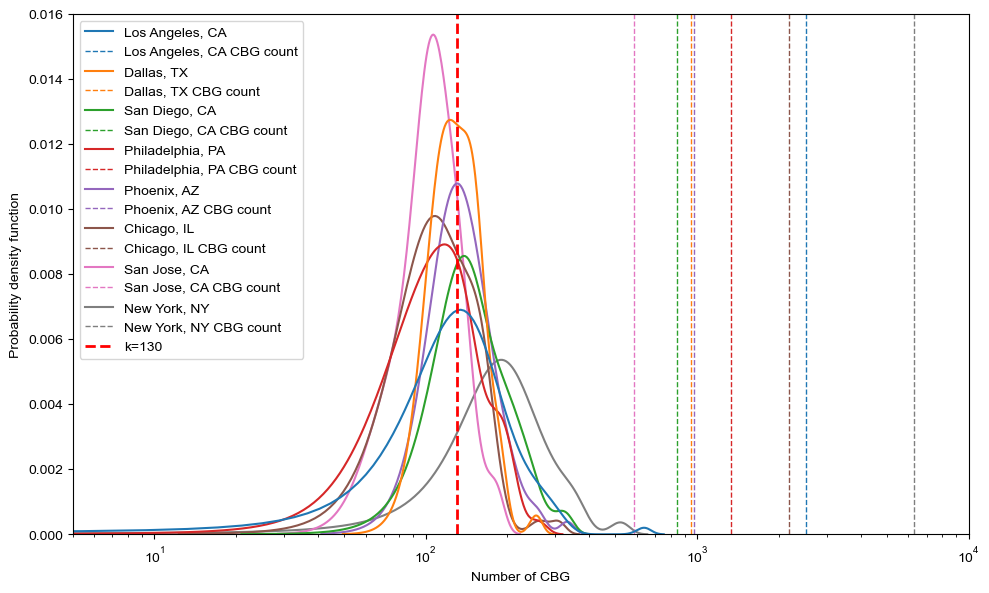

In [95]:
k_result_path = r"D:\repos\Top-k-network\scripts\k_select_US_newNY_2percent.csv"
df = pd.read_csv(k_result_path)
draw_hist(df, save = True, suffix=k_result_path.split("\\")[-1].split(".")[0])

# CCDF of degree distribution

In [11]:
import numpy as np
import networkx as nx
import geopandas as gpd
import pandas as pd
import networkx as nx

def extract_water_in_NY():
    cbgs = gpd.read_file(r"D:\Dropbox\urban cup\arcgis project\cbgs\cbgs_of_cities\NewYork\New_York_city.shp")
    with open(r'D:\Dropbox\urban cup\data\Mobility\id_dict_1.pkl', 'rb') as f:
        id_dict = pickle.load(f)

        # Extract the lines that not in cbgs but in id_dict
        id_dict_keys = list(id_dict.keys())
        cbgs_keys = list(cbgs['CBG_Code'].values)
        not_in_cbgs = []
        for i in id_dict_keys:
            if id_dict[id_dict_keys[i]] not in cbgs_keys:
                not_in_cbgs.append(i)
        return not_in_cbgs


def preprocess_flows(flow_matrix, percentile=2):
    """
    预处理流量数据，删除总度数前2%小的节点，然后取最大连通子图。
    
    :param flows: 原始流量矩阵（numpy array）
    :return: 处理过的流量矩阵（numpy array）
    """
    # Set the diagonal elements to zero
    np.fill_diagonal(flow_matrix, 0)

    # Create directed graph from flow matrix
    G = nx.from_numpy_array(flow_matrix, create_using=nx.DiGraph)

    # Convert graph to numpy adjacency matrix
    adj_matrix = nx.adjacency_matrix(G)
    numpy_array = adj_matrix.toarray()
    # Convert the original flows to binary
    flows_binary = (numpy_array > 0).astype(int)
    # Calculate the degrees based on the new definition
    degrees_all = np.sum(np.logical_or(flows_binary, flows_binary.T), axis=1)

    # Determine the 2% degree threshold
    percentile_threshold = np.percentile(degrees_all, percentile)

    # find the nodes whose degree are in the lowest 2%
    nodes_to_remove = np.where(degrees_all <= percentile_threshold)[0]
    print('Number of nodes to remove: ', len(nodes_to_remove))

    # Remove the nodes from the matrix
    reduced_matrix = np.delete(numpy_array, nodes_to_remove, axis=0)
    reduced_matrix = np.delete(reduced_matrix, nodes_to_remove, axis=1)

    # Create directed graph from the reduced matrix
    reduced_G = nx.from_numpy_array(reduced_matrix, create_using=nx.DiGraph)
    
    # Find all strongly connected components in the reduced graph
    scc = list(nx.strongly_connected_components(reduced_G))
    # Create a subgraph with only nodes in the largest SCC
    strongly_connected_G = reduced_G.subgraph(max(scc, key=len))
    processed_flows = nx.to_numpy_array(strongly_connected_G)
    return processed_flows

# 后续代码  
# 例如，使用此函数处理流量数据：
# flows = np.load('path_to_flows.npy')
# processed_flows = preprocess_flows(flows)




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import powerlaw
import pickle

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']

# 读取新的k值
k_values = pd.read_csv(r".\k_select_US_newNY_2percent.csv")

years = range(2018, 2022)

not_in_cbgs = extract_water_in_NY()

for year in years:
    for month in range(1, 13):
        # 创建一个包含10个子图的大图
        fig, axs = plt.subplots(2, 5, figsize=(20, 8))
        axs = axs.flatten()  # 将二维的子图数组转换为一维，方便迭代

        for city_idx, city in enumerate(cities):
            print(city_idx + 1, city)

            # 根据年份和月份从CSV文件中获取k值
            k = k_values.loc[(k_values['year'] == year) & (k_values['month'] == month), city].values[0]

            flows = np.load(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_=year, month_=str(month).zfill(2), city_=city_idx + 1))
            if city == 1:
                flows = np.delete(flows, not_in_cbgs, axis=0)
                flows = np.delete(flows, not_in_cbgs, axis=1)
            
            flows = preprocess_flows(flows)
            
            # Construct the graph for top-k outflows
            top_k_flows = np.zeros_like(flows)
            top_2k_flows = np.zeros_like(flows)
            top_k2_flows = np.zeros_like(flows)
            for i in range(flows.shape[0]):
                non_zero_flows = np.count_nonzero(flows[i])
                k_flows = min(k, non_zero_flows)
                k2k_flows = min(2 * k, non_zero_flows)
                kk2_flows = min(k // 2, non_zero_flows)
                if k_flows == 0:
                    continue
                top_k_indices = np.argpartition(flows[i], -k_flows)[-k_flows:]
                top_k_flows[i, top_k_indices] = 1
                top_2k_indices = np.argpartition(flows[i], -k2k_flows)[-k2k_flows:]
                top_2k_flows[i, top_2k_indices] = 1
                top_k2_indices = np.argpartition(flows[i], -kk2_flows)[-kk2_flows:]
                top_k2_flows[i, top_k2_indices] = 1

            # extract biggest connected component for top_k2_flows            
            G = nx.from_numpy_array(top_k2_flows, create_using=nx.DiGraph)
            Gc = max(nx.strongly_connected_components(G), key=len)
            top_k2_flows = nx.to_numpy_array(G.subgraph(Gc))
            
            flows_binary = (flows > 0).astype(int)
            degrees_all = np.sum(flows_binary, axis=0)
            degrees_k = np.sum(top_k_flows, axis=0)
            degrees_2k = np.sum(top_2k_flows, axis=0)
            degrees_k2 = np.sum(top_k2_flows, axis=0)

            sorted_degrees = sorted(degrees_all, reverse=True)
            sorted_degrees_k = sorted(degrees_k, reverse=True)
            sorted_degrees_2k = sorted(degrees_2k, reverse=True)
            sorted_degrees_k2 = sorted(degrees_k2, reverse=True)

            # Calculate the CCDF
            ccdf = [(i / len(sorted_degrees)) for i in range(len(sorted_degrees))]
            ccdf_k = [(i / len(sorted_degrees_k)) for i in range(len(sorted_degrees_k))]
            ccdf_2k = [(i / len(sorted_degrees_2k)) for i in range(len(sorted_degrees_2k))]
            ccdf_k2 = [(i / len(sorted_degrees_k2)) for i in range(len(sorted_degrees_k2))]

            #fit = powerlaw.Fit(sorted_degrees_k, discrete=True)

            # 绘制子图
            ax = axs[city_idx]
            colors = ['#eb7c77', '#f0a015', '#329291', '#2c4eaa']
            ax.plot(sorted_degrees[::-1], ccdf[::-1], 'o', color=colors[0], label='All Flows', markersize=3)
            ax.plot(sorted_degrees_k[::-1], ccdf_k[::-1], 's', color=colors[1], label='Top-k Outflows', markersize=3)
            ax.plot(sorted_degrees_2k[::-1], ccdf_2k[::-1], '^', color=colors[2], label='Top-2k Outflows', markersize=3)
            ax.plot(sorted_degrees_k2[::-1], ccdf_k2[::-1], 'o', color=colors[3], label='Top-k/2 Outflows', markersize=3)
            #fit.power_law.plot_ccdf(ax=ax, color='black', linestyle='--', label='Power Law Fit')

            ax.set_xlabel('In-Degree')
            ax.set_ylabel('Pc(Degree)')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.tick_params(direction='in', length=6, width=0.5, colors='k', which='both')
            ax.set_title("{city}, {year}/{month}".format(city=city, year=year, month=month))
            ax.legend()

        plt.tight_layout()
        plt.savefig(r"D:\repos\Top-k-network\results\powerlaw_5percent\ccdf_in_degree_distribution_{year}_{month}.png".format(year=year, month=month), dpi=300)
        plt.show()


1 New York, NY
Number of nodes to remove:  139
2 Los Angeles, CA
Number of nodes to remove:  51
3 Chicago, IL
Number of nodes to remove:  44
4 Houston, TX
5 Phoenix, AZ
Number of nodes to remove:  21
6 Philadelphia, PA
Number of nodes to remove:  28
7 San Antonio, TX
8 San Diego, CA
Number of nodes to remove:  17
9 Dallas, TX
Number of nodes to remove:  20
10 San Jose, CA
Number of nodes to remove:  12


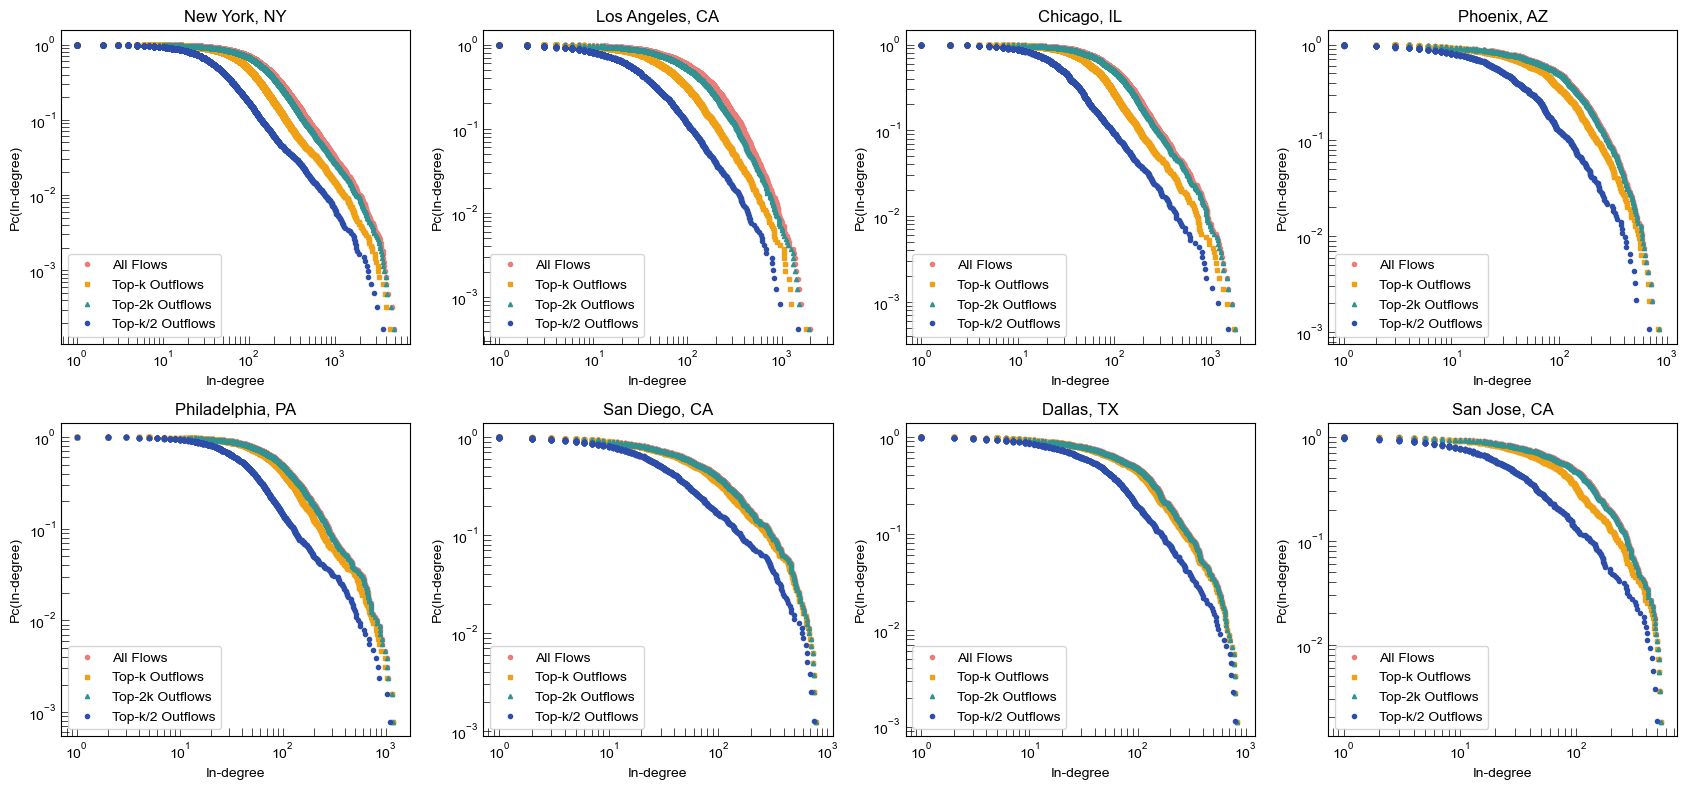

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import powerlaw
import pickle

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']

# 读取新的k值
k_values = pd.read_csv(r".\k_select_US_newNY_2percent.csv")

years = range(2018, 2022)

not_in_cbgs = extract_water_in_NY()

year = 2018
month = 5
# 创建一个包含10个子图的大图
fig, axs = plt.subplots(2, 4, figsize=(17, 8))
axs = axs.flatten()  # 将二维的子图数组转换为一维，方便迭代
count = -1
for city_idx, city in enumerate(cities):
    
    print(city_idx + 1, city)

    # 根据年份和月份从CSV文件中获取k值
    k = k_values.loc[(k_values['year'] == year) & (k_values['month'] == month), city].values[0]

    flows = np.load(r'D:\Dropbox\urban cup\data\Mobility\cbg_visit_{year_}-{month_}_{city_}.npy'.format(year_=year, month_=str(month).zfill(2), city_=city_idx + 1))
    if city == 1:
        flows = np.delete(flows, not_in_cbgs, axis=0)
        flows = np.delete(flows, not_in_cbgs, axis=1)
    elif city_idx == 3 or city_idx == 6:
        continue
    count +=1
    flows = preprocess_flows(flows)
    
    # Construct the graph for top-k outflows
    top_k_flows = np.zeros_like(flows)
    top_2k_flows = np.zeros_like(flows)
    top_k2_flows = np.zeros_like(flows)
    for i in range(flows.shape[0]):
        non_zero_flows = np.count_nonzero(flows[i])
        k_flows = min(k, non_zero_flows)
        k2k_flows = min(2 * k, non_zero_flows)
        kk2_flows = min(k // 2, non_zero_flows)
        if k_flows == 0:
            continue
        top_k_indices = np.argpartition(flows[i], -k_flows)[-k_flows:]
        top_k_flows[i, top_k_indices] = 1
        top_2k_indices = np.argpartition(flows[i], -k2k_flows)[-k2k_flows:]
        top_2k_flows[i, top_2k_indices] = 1
        top_k2_indices = np.argpartition(flows[i], -kk2_flows)[-kk2_flows:]
        top_k2_flows[i, top_k2_indices] = 1

    # extract biggest connected component for top_k2_flows            
    G = nx.from_numpy_array(top_k2_flows, create_using=nx.DiGraph)
    Gc = max(nx.strongly_connected_components(G), key=len)
    top_k2_flows = nx.to_numpy_array(G.subgraph(Gc))
    
    flows_binary = (flows > 0).astype(int)
    degrees_all = np.sum(flows_binary, axis=0)
    degrees_k = np.sum(top_k_flows, axis=0)
    degrees_2k = np.sum(top_2k_flows, axis=0)
    degrees_k2 = np.sum(top_k2_flows, axis=0)

    sorted_degrees = sorted(degrees_all, reverse=True)
    sorted_degrees_k = sorted(degrees_k, reverse=True)
    sorted_degrees_2k = sorted(degrees_2k, reverse=True)
    sorted_degrees_k2 = sorted(degrees_k2, reverse=True)

    # Calculate the CCDF
    ccdf = [(i / len(sorted_degrees)) for i in range(len(sorted_degrees))]
    ccdf_k = [(i / len(sorted_degrees_k)) for i in range(len(sorted_degrees_k))]
    ccdf_2k = [(i / len(sorted_degrees_2k)) for i in range(len(sorted_degrees_2k))]
    ccdf_k2 = [(i / len(sorted_degrees_k2)) for i in range(len(sorted_degrees_k2))]

    #fit = powerlaw.Fit(sorted_degrees_k, discrete=True)

    # 绘制子图
    ax = axs[count]
    colors = ['#eb7c77', '#f0a015', '#329291', '#2c4eaa']
    ax.plot(sorted_degrees[::-1], ccdf[::-1], 'o', color=colors[0], label='All Flows', markersize=3)
    ax.plot(sorted_degrees_k[::-1], ccdf_k[::-1], 's', color=colors[1], label='Top-k Outflows', markersize=3)
    ax.plot(sorted_degrees_2k[::-1], ccdf_2k[::-1], '^', color=colors[2], label='Top-2k Outflows', markersize=3)
    ax.plot(sorted_degrees_k2[::-1], ccdf_k2[::-1], 'o', color=colors[3], label='Top-k/2 Outflows', markersize=3)
    #fit.power_law.plot_ccdf(ax=ax, color='black', linestyle='--', label='Power Law Fit')

    ax.set_xlabel('In-degree')
    ax.set_ylabel('Pc(In-degree)')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(direction='in', length=6, width=0.5, colors='k', which='both')
    ax.set_title("{city}".format(city=city))
    ax.legend()

plt.tight_layout()
plt.savefig(r"D:\repos\Top-k-network\results\ccdf_in_degree_distribution_{year}_{month}.png".format(year=year, month=month), dpi=300)
plt.show()


# Temporal trend of k*

['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12']


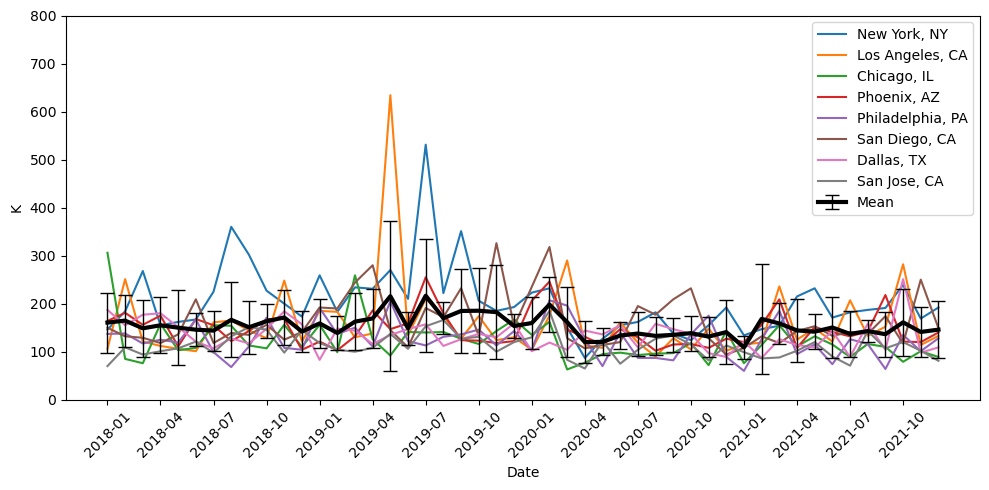

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.lines import Line2D
# Plotting
cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
cbg_counts =[6493, 2509, 2183, 1568, 972, 1336, 929, 845, 946, 583]
years = range(2018,2022)
city_list = list(range(1,11))
delete_degrees = [5, 10, 15, 20, 30, 40, 50, 70, 90, 110, 130, 150, 200, 250]
month_year_labels = []

palette = sns.color_palette()

import matplotlib.pyplot as plt

k_result_path = r"D:\repos\Top-k-network\scripts\k_select_US_newNY_5percent.csv"
df = pd.read_csv(k_result_path,index_col=0)
suffix=k_result_path.split("_")[-1].split(".")[0]

# Drop year >2021
df = df.loc[df["year"] <= 2021]

for year in years:
    for month in range(1,13):
        #if year == 2022 and month > 3:
        #    break
        month_year_labels.append("{year_}-{month_}".format(month_ = str(month).zfill(2), year_ = year))

df.drop(['year','month'], axis=1, inplace=True)
#df.drop(['Houston, TX','San Antonio, TX'], axis=1, inplace=True)
df["mean"] = df.mean(axis=1)

# 计算标准偏差
# using the columes except the mean column
df["std"] = df.loc[:, df.columns[:-1]].std(axis=1)

# 创建一个图形
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

# 对每个城市进行绘制
for city in cities:
    if city == 'Houston, TX' or city =='San Antonio, TX': continue
    ax.plot(df.loc[:,city].to_list(), label=city,)


# 设置标题、轴标签等
#ax.set_title('K across time')
ax.set_xlabel('Date')
ax.set_ylabel('K')

# 调整x轴标签以展示年-月
#num_months = len(df.index.unique())
num_months = len(month_year_labels)
# 删除旧的平均值线
#ax.plot(df.loc[:,"mean"].to_list(), label="mean", color="black", linewidth=3)

# 使用errorbar绘制平均值线及其误差
ax.errorbar(range(num_months), df["mean"].to_list(), yerr=df["std"].to_list(),label="Mean", color="black", linewidth=3,elinewidth=1, capsize=5, capthick=1, )

ax.set_xticks(list(range(num_months))[::3])
print((month_year_labels))
ax.set_xticklabels(month_year_labels[::3], rotation=45, )


ax.legend()
ax.set_ylim(0, 800)
plt.tight_layout()
plt.savefig("k_across_time_with_error_bar_{}.png".format(suffix), dpi=300)
plt.show()





['2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02', '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08', '2021-09', '2021-10', '2021-11', '2021-12']


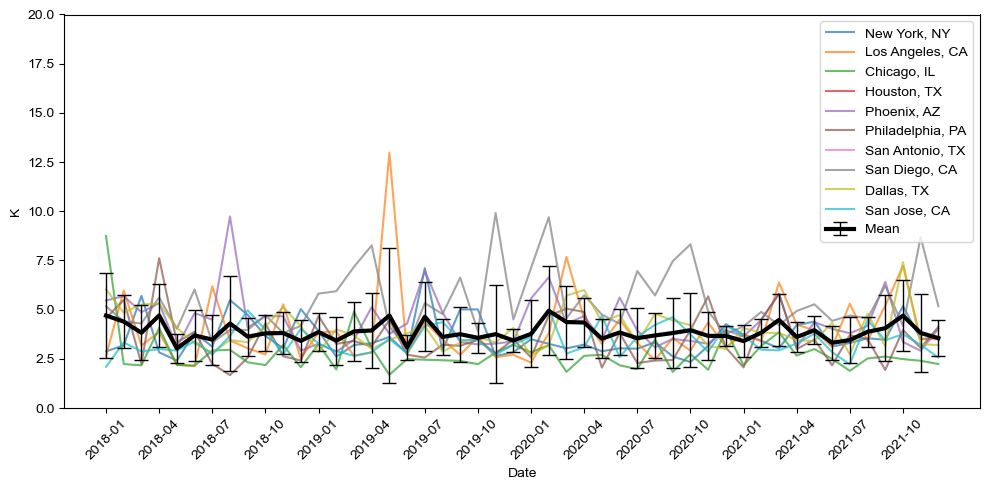

In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from matplotlib.lines import Line2D
# Plotting
cities = ['New York, NY', 'Los Angeles, CA', 'Chicago, IL', 'Houston, TX', 'Phoenix, AZ', 'Philadelphia, PA', 'San Antonio, TX', 'San Diego, CA', 'Dallas, TX', 'San Jose, CA']
cbg_counts =[6493, 2509, 2183, 1568, 972, 1336, 929, 845, 946, 583]
years = range(2018,2022)
city_list = list(range(1,11))
delete_degrees = [5, 10, 15, 20, 30, 40, 50, 70, 90, 110, 130, 150, 200, 250]
month_year_labels = []

palette = sns.color_palette()
import matplotlib.pyplot as plt
#k_result_path = r"D:\repos\Top-k-network\scripts\k_select_US_newNY_3percent.csv"

k_result_path = r"D:\repos\Top-k-network\results\k_normed3.csv"
df = pd.read_csv(k_result_path,index_col=0)
suffix=k_result_path.split("_")[-1].split(".")[0]


for year in years:
    for month in range(1,13):
        if year == 2022 and month > 3:
            break
        month_year_labels.append("{year_}-{month_}".format(month_ = str(month).zfill(2), year_ = year))

#df.drop(['year','month'], axis=1, inplace=True)
df = df.loc[:47,:]
#df.drop(['Houston, TX','San Antonio, TX'], axis=1, inplace=True)
df["mean"] = df.mean(axis=1)

# 计算标准偏差
# using the columes except the mean column
df["std"] = df.loc[:, df.columns[:-1]].std(axis=1)

# 创建一个图形
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)

# 对每个城市进行绘制
for city in cities:
    #if city == 'Houston, TX' or city =='San Antonio, TX': continue
    ax.plot(df.loc[:,city].to_list(), label=city, alpha=0.7, color=palette[cities.index(city)])


# 设置标题、轴标签等
#ax.set_title('K across time')
ax.set_xlabel('Date')
ax.set_ylabel('Percolation thresholds')

# 调整x轴标签以展示年-月
num_months = len(df.index.unique())
# 删除旧的平均值线
#ax.plot(df.loc[:,"mean"].to_list(), label="mean", color="black", linewidth=3)

# 使用errorbar绘制平均值线及其误差
ax.errorbar(range(num_months), df["mean"].to_list(), yerr=df["std"].to_list(),label="Mean", color="black", linewidth=3,elinewidth=1, capsize=5, capthick=1, )

ax.set_xticks(list(range(num_months))[::3])
print((month_year_labels))
ax.set_xticklabels(month_year_labels[::3], rotation=45, )


ax.legend()
ax.set_ylim(0, 20)
plt.tight_layout()
#plt.savefig("k_across_time_with_error_bar_{}.png".format(suffix), dpi=300)
plt.show()





In [47]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Load the data
df = pd.read_csv(r".\k_select_US_newNY_5percent.csv", index_col=0)
df.drop(['year','month'], axis=1, inplace=True)
mean_values = df.mean(axis=1)

# Split the data into pre-COVID and post-COVID segments based on April 2020 index
april_2020_index = 28  # 0-based index for April 2020
pre_covid_data = mean_values[:april_2020_index]
post_covid_data = mean_values[april_2020_index:]

# Function to run linear regression and report results
def run_regression_and_report(data_segment, segment_name):
    X = np.array(range(len(data_segment))).reshape(-1, 1)
    X_const = sm.add_constant(X)
    model = sm.OLS(data_segment, X_const).fit()
    coef = model.params[1]
    std_error = model.bse[1]
    p_value = model.pvalues[1]
    
    print(f"Results for {segment_name}:")
    print(f"Coefficient: {coef:.4f}")
    print(f"Standard Error: {std_error:.4f}")
    print(f"P-Value: {p_value:.4f}")
    print("--------------------------------------------------")

# Run regression and report results for both segments
run_regression_and_report(pre_covid_data, "Pre-COVID-19")
run_regression_and_report(post_covid_data, "Post-COVID-19")


Results for Pre-COVID-19:
Coefficient: 0.6998
Standard Error: 0.5010
P-Value: 0.1743
--------------------------------------------------
Results for Post-COVID-19:
Coefficient: 1.3750
Standard Error: 0.3792
P-Value: 0.0016
--------------------------------------------------
